## Study Space Availability: Yearly Patterns

In [2]:
import numpy as np
import pandas as pd

DATA_PATH = "data/final_data.csv"
REF_YEAR = 2024

# --- load ---
df = pd.read_csv(DATA_PATH)
df["t10"] = pd.to_datetime(df["t10"], errors="coerce")
df = df.dropna(subset=["t10"]).copy()
df = df.set_index("t10").sort_index()

# --- define sufficient availability ---
df["sufficient_availability"] = np.where(
    df["relative_availability"].isna(),
    np.nan,
    (df["relative_availability"] > 0.1).astype(int)
)

# --- daily percent of sufficient availability ---
daily_percent = df["sufficient_availability"].resample("D").apply(
    lambda x: 100.0 * x.sum() / x.count() if x.count() else np.nan
).to_frame("pct_sufficient")

# drop Feb 29 for consistent year length
daily_percent = daily_percent[~((daily_percent.index.month == 2) & (daily_percent.index.day == 29))].copy()

# add year / day-of-year / theta
daily_percent["year"] = daily_percent.index.year
daily_percent["doy"] = daily_percent.index.dayofyear
daily_percent["theta"] = 2 * np.pi * (daily_percent["doy"] - 1) / 366.0

# 7-day rolling mean per year
daily_percent = daily_percent.sort_values(["year", "doy"])
daily_percent["pct_sufficient_rm"] = (
    daily_percent.groupby("year")["pct_sufficient"]
    .transform(lambda s: s.rolling(7, min_periods=1).mean())
)

daily = daily_percent[["year", "theta", "pct_sufficient_rm"]].dropna().copy()

# Mean curve across years
mean_curve = (
    daily.groupby("theta", as_index=False)["pct_sufficient_rm"]
    .mean()
    .rename(columns={"pct_sufficient_rm": "mean_rm"})
)

# Exam phases
exam_phases = [(15, 55), (200, 230)]

# ISO weeks for CW labels
jan4 = pd.Timestamp(REF_YEAR, 1, 4)
iso_start = jan4 - pd.to_timedelta(jan4.weekday(), unit="D")
mondays = pd.date_range(iso_start, f"{REF_YEAR}-12-28", freq="W-MON")
mondays = mondays[mondays.year == REF_YEAR]

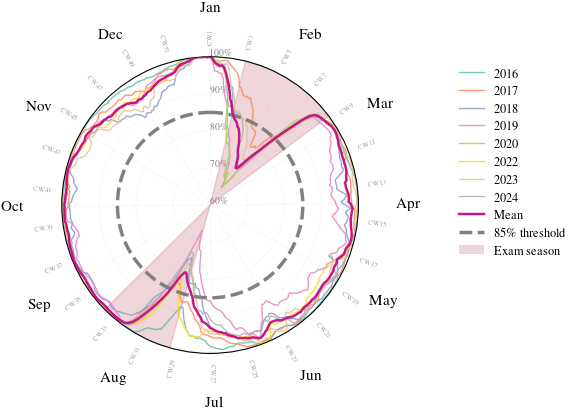

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch
from tueplots import bundles
from tueplots.constants.color import rgb # Falls Fehler, 'colors' probieren

# -----------------------
# 1. TUEPLOTS SETTINGS
# -----------------------
# Nutze "full" column für gute Sichtbarkeit der Details
plt.rcParams.update(bundles.icml2024(column="full", nrows=1, ncols=1))

# -----------------------
# 2. SETUP FIGURE
# -----------------------
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': 'polar'})

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

# Skalierung (radial)
RADIAL_MIN, RADIAL_MAX = 60, 100
ax.set_ylim(RADIAL_MIN, RADIAL_MAX)
ax.set_rlabel_position(0) # Position der %-Skala bei 0 Grad (Nord)

# -----------------------
# 3. COLORS (Kräftiges Set2 & Uni-Farben)
# -----------------------
years = sorted(daily["year"].unique())
ccmap = plt.get_cmap("Set2")
n_years = len(years)

# Kräftige Highlights für das Paper
MEAN_COLOR = "mediumvioletred"           # Tiefschwarz für den Durchschnitt
THRESHOLD_COLOR = "grey"    # Uni Tübingen Gold
EXAM_COLOR = "#a51e37"         # Uni Tübingen Rot (für Exam-Phasen)

# -----------------------
# 4. PLOTTING
# -----------------------

# Jahreslinien (Set2) - Kräftiger
for i, y in enumerate(years):
    dy = daily[daily["year"] == y]
    ax.plot(
        dy["theta"],
        dy["pct_sufficient_rm"],
        color=ccmap(i / (n_years if n_years > 1 else 1)),
        linewidth=1,       # Dickere Linie
        alpha=0.9,           # Fast voll deckend
        label=str(y),
        zorder=2
    )

# Mean Line (Hervorgehoben)
ax.plot(
    mean_curve["theta"],
    mean_curve["mean_rm"],
    color=MEAN_COLOR,
    linewidth=1.75,           # Extra dick
    label="Mean",
    zorder=10
)

# Threshold Line
EXAM_LINE = 85
theta_grid = np.linspace(0, 2 * np.pi, 500)
ax.plot(
    theta_grid,
    np.full_like(theta_grid, EXAM_LINE),
    color=THRESHOLD_COLOR,
    linestyle="--",
    linewidth=2.5,
    label=f"{EXAM_LINE}\\% threshold",
    zorder=5
)

# Exam Season Shading (Kräftigeres Rot/Grau-Mix)
for s_doy, e_doy in exam_phases:
    th_s = 2 * np.pi * (s_doy - 1) / 366.0
    th_e = 2 * np.pi * (e_doy - 1) / 366.0
    ax.axvspan(th_s, th_e, color=EXAM_COLOR, alpha=0.18, zorder=1)

# -----------------------
# 5. LABELS: % & CW & MONTHS
# -----------------------

# 5a. Radial: % Beschriftung
rticks = np.arange(60, 101, 10)
ax.set_yticks(rticks)
ax.set_yticklabels([f"{r}\\%" for r in rticks], fontsize=7, color="gray", zorder=20)

# 5b. Monate (Ganz außen als Rahmen)
month_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
month_starts = pd.date_range(f"{REF_YEAR}-01-01", f"{REF_YEAR}-12-01", freq="MS")
month_thetas = 2 * np.pi * (month_starts.dayofyear - 1) / 366.0

ax.set_xticks(month_thetas)
ax.set_xticklabels(month_labels, fontsize=11, fontweight='bold')
# WICHTIG: Erhöhe das Pad deutlich (ca. 45), da die CWs nun weit nach außen ragen
ax.tick_params(axis='x', pad=25) 

# 5c. CW: Kalenderwochen (Radial wie echte Sonnenstrahlen)
r_cw = 103.0  # Startpunkt direkt über der 100%-Linie

for d in mondays:
    w = d.isocalendar()[1]
    theta = 2 * np.pi * (d.dayofyear - 1) / 366.0
    angle_deg = np.degrees(theta)

    # Berechnung der Rotation für radiale Ausrichtung (Sunbeams)
    # Da Matplotlibs 'rotation' absolut ist, müssen wir den Winkel anpassen.
    # Basis: 90 Grad - Positionswinkel (wegen Nord-Ausrichtung)
    base_rot = 90 - angle_deg
    
    # Flip-Logik für die Lesbarkeit (linke vs. rechte Seite des Kreises)
    # Damit das 'C' immer innen ist und der Text nicht auf dem Kopf steht:
    if 180 < angle_deg:
        display_rot = base_rot + 180  # Text umdrehen
        alignment = 'right'           # Ende des Wortes ist außen -> C ist innen
    else:
        display_rot = base_rot        # Normal lassen
        alignment = 'left'            # Anfang des Wortes (C) ist innen

    if w % 2 != 0: # Jede 2. Woche für Klarheit
        ax.text(
            theta, r_cw, f"CW{w}", 
            fontsize=5, 
            color="gray", 
            ha=alignment,      # Dynamischer Anker (left oder right)
            va="center", 
            rotation=display_rot, 
            rotation_mode='anchor',
            alpha=0.8
        )
    
    # Markierungsstriche (die Strahlen-Basis)
    ax.plot([theta, theta], [100, 101.5], color="darkgray", lw=0.6, zorder=1)

# -----------------------
# 6. LEGEND & FINISH
# -----------------------
ax.grid(True, alpha=0.2, linestyle=":")

# Legende kompakter und besser positioniert
exam_patch = Patch(facecolor=EXAM_COLOR, alpha=0.18, label="Exam season")
handles, labels = ax.get_legend_handles_labels()
# Doppelte Labels filtern
by_label = dict(zip(labels, handles))
by_label["Exam season"] = exam_patch

ax.legend(
    by_label.values(), by_label.keys(),
    loc="upper left", 
    bbox_to_anchor=(1.3, 1.0), # Position rechts neben dem Chart
    frameon=False,
    fontsize=9
)

plt.savefig("study_availability_icml.pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()